## Wattsight / Volue API
Dokumentasjon finnes her:
- https://wattsight-wapi-python.readthedocs-hosted.com/en/master/ 
- relevante kurver / tidsserier kan man finne her: https://api.volueinsight.com/#
- Credentials kan du generere her: https://auth.volueinsight.com/account/oauth-clients 

In [1]:
import wapi # wattsights egen pakke / den må installers via `pip install wapi-python`
import pandas as pd
import os
import numpy as np
from datetime import datetime 
from datetime import timedelta

In [2]:
# Create a session
# Dette forutsetter at dere har lagret volue credentials som miljøvariabler på PC'en deres og med navnet `WS_CLIENT_ID` og `WS_CLIENT_SECRET`
user = os.getenv("WS_CLIENT_ID")
password = os.getenv("WS_CLIENT_SECRET")
session = wapi.Session(client_id=user, client_secret=password)

## Curve type: Time series
https://wattsight-wapi-python.readthedocs-hosted.com/en/master/curves.html#getting-data-from-a-time-series-curve

In [ ]:
start = '2021-03-01'
end = '2021-03-07'
curve = session.get_curve(name='exc dk1>de ntc mw cet h a') 
ts = curve.get_data(data_from=start, data_to=end, function='SAVERAGE', frequency='H')
pd_s = ts.to_pandas()
print(pd_s)

## Curve type: tagged instances
https://wattsight-wapi-python.readthedocs-hosted.com/en/master/curves.html#getting-data-from-a-tagged-instances-curve

In [ ]:
curve = session.get_curve(name='pro de-ttg wnd ec12ens mwh/h cet min15 f')
ts_list = curve.get_instance(issue_date='2021-03-01T00:00', tag='Avg')
pd_s = ts_list.to_pandas()
print(pd_s)

In [3]:
start = '2022-01-01'
end = '2022-03-27'
periods=pd.date_range(start,end,freq='D')

curves = ['con no1 mwh/h cet min15 a',
'tt no1 con ec00 °c cet min15 f',
'pro no1 wnd ec00 mwh/h cet min15 f',
'pro no1 spv ec00 mwh/h cet min15 f'
]

df_watt = pd.DataFrame()
for curve in curves:
    print(f"Working with {curve}")
    curve = session.get_curve(name=curve)
    curve_type = curve.curve_type
    res = []
    counter = 1
    if curve_type == 'TIME_SERIES':
        ts = curve.get_data(data_from=start, data_to=end, function='SAVERAGE', frequency='H')
        watt_temp = ts.to_pandas()
        df_watt = pd.merge(df_watt, watt_temp, left_index=True, right_index=True, how='outer')
        continue
    
    for j in range(len(periods)):
        if j == len(periods)-1:
            continue
        if curve_type == 'TAGGED_INSTANCES':
            ts_list = curve.search_instances(issue_date_from=periods[j],
                                 issue_date_to=periods[j+1],
                                 with_data=True, function='SAVERAGE', frequency='H', tags=['Avg'])
        else: #curve_type == 'INSTANCES'
            ts_list = curve.search_instances(issue_date_from=periods[j],
                                 issue_date_to=periods[j+1],
                                 with_data=True, function='SAVERAGE', frequency='H')
        # check if ts_list is empty and if yes, jump over that timestamp
        if not ts_list:
            continue
        pd_s = ts_list[0].to_pandas()
        if pd_s.empty:
            continue
        pd_s = pd_s.sort_index(ascending=True)
        pd_s = pd_s[:24]
        res.append(pd_s)
        print(f'Done {counter} out of {len(periods)}')
        counter += 1

    for k in range(len(res)):
        if k == 0:
            watt = pd.Series(res[k])
        else:
            watt = pd.concat([watt, res[k]])
    watt_temp = watt.rename(curve)
    df_watt = pd.merge(df_watt, watt_temp, left_index=True, right_index=True, how='outer')


Working with con no1 mwh/h cet min15 a
Working with tt no1 con ec00 °c cet min15 f
Done 1 out of 86
Done 2 out of 86
Done 3 out of 86
Done 4 out of 86
Done 5 out of 86
Done 6 out of 86
Done 7 out of 86
Done 8 out of 86
Done 9 out of 86
Done 10 out of 86
Done 11 out of 86
Done 12 out of 86
Done 13 out of 86
Done 14 out of 86
Done 15 out of 86
Done 16 out of 86
Done 17 out of 86
Done 18 out of 86
Done 19 out of 86
Done 20 out of 86
Done 21 out of 86
Done 22 out of 86
Done 23 out of 86
Done 24 out of 86
Done 25 out of 86
Done 26 out of 86
Done 27 out of 86
Done 28 out of 86
Done 29 out of 86
Done 30 out of 86
Done 31 out of 86
Done 32 out of 86
Done 33 out of 86
Done 34 out of 86
Done 35 out of 86
Done 36 out of 86
Done 37 out of 86
Done 38 out of 86
Done 39 out of 86
Done 40 out of 86
Done 41 out of 86
Done 42 out of 86
Done 43 out of 86
Done 44 out of 86
Done 45 out of 86
Done 46 out of 86
Done 47 out of 86
Done 48 out of 86
Done 49 out of 86
Done 50 out of 86
Done 51 out of 86
Done 52 

In [4]:
df_watt.columns = ["cons_actual", "temp_forecast", "wind_forecast", "solar_forecast"]
df_watt.dropna(inplace=True)
df_watt.head()

,cons_actual,temp_forecast,wind_forecast,solar_forecast
2022-01-01 00:00:00+01:00,4779.0,-0.1,88.8348,0.0
2022-01-01 01:00:00+01:00,4701.0,-0.6,88.8348,0.0
2022-01-01 02:00:00+01:00,4681.0,-0.4,61.2504,0.0
2022-01-01 03:00:00+01:00,4620.0,-1.0,49.7388,0.0
2022-01-01 04:00:00+01:00,4645.0,-1.7,39.3132,0.0


In [11]:
df_watt.reset_index().rename(columns={'index':'date'})

,date,cons_actual,temp_forecast,wind_forecast,solar_forecast
0,2022-01-01 00:00:00+01:00,4779.0,-0.1,88.834800,0.0
1,2022-01-01 01:00:00+01:00,4701.0,-0.6,88.834800,0.0
2,2022-01-01 02:00:00+01:00,4681.0,-0.4,61.250400,0.0
3,2022-01-01 03:00:00+01:00,4620.0,-1.0,49.738800,0.0
4,2022-01-01 04:00:00+01:00,4645.0,-1.7,39.313200,0.0
...,...,...,...,...,...
2053,2022-03-26 19:00:00+01:00,3976.0,2.9,44.529964,0.0
2054,2022-03-26 20:00:00+01:00,3888.0,2.3,28.286329,0.0
2055,2022-03-26 21:00:00+01:00,3785.0,1.3,38.928711,0.0
2056,2022-03-26 22:00:00+01:00,3675.0,0.5,57.132784,0.0


### Er en forklaringsvariabel en god fit? Se f.eks. på korrelasjon

In [30]:
print(f'Korrelasjon mellom faktisk forbruk og temperaturprognose for NO1 er {df_watt["cons_actual"].corr(df_watt["temp_forecast"])}')

Korrelasjon mellom faktisk forbruk og temperaturprognose for NO1 er -0.46047731650168733


In [ ]:
# If you want to save some results as a csv
working_directory = os.getcwd()
print(f"Your current working directory: {working_directory}")
path = os.path.join(working_directory, "Wattsight.csv")
df_watt.to_csv(path,index=True, decimal='.')

## ML

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

In [6]:
# del datasettet i forklarende variabler og målvariabler / trenings- og testsett
X = df_watt[["temp_forecast", "wind_forecast", "solar_forecast"]]
y = df_watt[["cons_actual"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

<AxesSubplot:xlabel='index'>

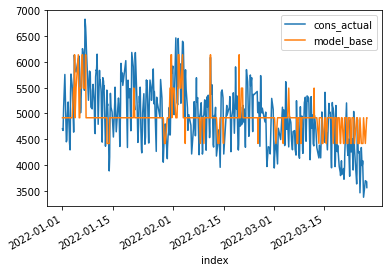

In [7]:
# Start med en modell hvor du setter hyperparameterne til en (tilfeldig) verdi
model_base = DecisionTreeRegressor(max_depth= 2,random_state = 0).fit(X_train, y_train)
model_base_prediction = model_base.predict(X_test)

base = y_test.reset_index()
base['model_base'] = model_base_prediction
base = base.set_index('index')
base.plot()